#  Logistic Regression and Classification Error Metrics

### LIC - Prof. Rogério - Marco Túlio S. da Mata 20193007156

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [41]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1: CSV Data import and Dataframe creation

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [42]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [43]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [44]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [45]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [46]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [47]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

4203    2
3166    3
2432    1
9331    4
6470    2
Name: Activity, dtype: int32

Comment: Counting classes from the csv file to separate data types, changing type by setting them as float(except for "Activity" column), defiining min and max values from the df and enconding labels to serve as indexes for values from 0 to 5 

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [49]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

Comment: Calculating the correlation values between pairs, it determines how much linear dependency there are in the features

A histogram of the absolute value correlations.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

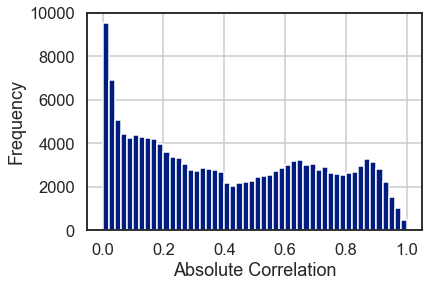

In [51]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [52]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


Comment: Determining from -1 to 1 the correlation degree between features

## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

Comment: defining training and test sets (30% and 70%, respectively) 

In [54]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitt ing a multi-class model so you understand the coefficient output. Store the model.

In [ ]:
from sklearn.linear_model import LogisticRegression
import warnings
import time
warnings.filterwarnings("ignore")

# Standard logistic regressio
# args -> https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
solvers = ['saga', 'lbfgs', 'newton-cholesky', 'newton-cg', 'sag', 'liblinear']
models = dict()
dts = list()

# We're gonna use different solver methods to check accuracy and performance 
for solver in solvers:
	start_time = time.time()
	temp = LogisticRegression(penalty='l2', C=10.0, solver=solver).fit(X_train, y_train)
	y_predict = temp.predict(X_test)
	end_time = time.time()
	models[solver]=temp
	dts.append(end_time - start_time)

## Question 5

Calculate the following error metric: 

* accuracy & performance


In [ ]:
for i, model in enumerate(models.keys()):
	print(f"{solvers[i]}: \n accuracy {models[model].score(X_test, y_test)} dt: {dts[i]}")

saga: 
 accuracy 0.983495145631068 dt: 17.9417781829834
lbfgs: 
 accuracy 0.9812297734627832 dt: 1.5869717597961426
newton-cholesky: 
 accuracy 0.9831715210355987 dt: 10.074411630630493
newton-cg: 
 accuracy 0.9854368932038835 dt: 22.82907748222351
sag: 
 accuracy 0.983495145631068 dt: 13.727505207061768
liblinear: 
 accuracy 0.9831715210355987 dt: 9.509752988815308


* check n first results

In [ ]:
y_predictions = models["lbfgs"].predict(X_test)
for i, pred in enumerate(y_predictions[:10]):
    print(f'y_predicted: {pred} y_test: {y_test.iloc[i]}')

y_predicted: 3 y_test: 3
y_predicted: 5 y_test: 5
y_predicted: 3 y_test: 3
y_predicted: 1 y_test: 1
y_predicted: 0 y_test: 0
y_predicted: 5 y_test: 5
y_predicted: 0 y_test: 0
y_predicted: 2 y_test: 2
y_predicted: 0 y_test: 0
y_predicted: 0 y_test: 0


Comments: newton-cg method is the closest to one in accuracy, though it had a long exec time, lbfgs(the std method) ran faster but lightly less accurate, therefore the best score overall.